In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

# interpolation

In [2]:
files = {
    'fasttext': 'log/WRD_COS_interpolation_fasttext.csv',
    'fasttext_sw': 'log/WRD_COS_interpolation_fasttext_sw.csv',
    'glove42b': 'log/WRD_COS_interpolation_glove42b.csv',
    'glove840b':'log/WRD_COS_interpolation_glove840b.csv',
    'paragram': 'log/WRD_COS_interpolation_paragram.csv',
    'paranmt': 'log/WRD_COS_interpolation_paranmt.csv',
    'psl': 'log/WRD_COS_interpolation_psl.csv'
}

In [153]:
def plot_interp(k):
    df = pd.read_csv(files[k])
    c_arr = df['coef_C'].unique()
    p_arr = df['coef_P'].unique()
    interp_matrix = np.zeros((len(c_arr), len(p_arr)))

    for i, (c, p, l, m, r) in df.iterrows():
        ic = i // len(p_arr)
        ip = i % len(p_arr)
        interp_matrix[ic, ip] = m
    fig, ax = plt.subplots()
    m = np.min(interp_matrix)
    M = np.max(interp_matrix)
    d = (M - m) / 4
    levels = [m]
    cursor = m

    for l in range(3):
        for _ in range(3):
            cursor += d
            levels.append(cursor)
        d /= 4
    levels.append(M)
    
    im = ax.contourf(interp_matrix[:, :11], cmap='cool', levels=levels)
    ax.set_xticks(np.arange(11))
    ax.set_xticklabels(["{:.2f}".format(v) for v in p_arr[:11].tolist()], rotation=90)
    ax.set_yticks(np.arange(11))
    ax.set_yticklabels(["{:.1f}".format(v) for v in c_arr.tolist()])
    
    ind = np.unravel_index(np.argmax(interp_matrix, axis=None), interp_matrix.shape)
    print(ind)
    ax.scatter(ind[1], ind[0], c='r')

    
    ax.set_title("interpolation of WRD and COS with {} vector".format(k))
    fig.colorbar(im)

(1, 1)
(0, 0)
(0, 0)
(0, 0)
(3, 2)
(5, 3)
(3, 2)


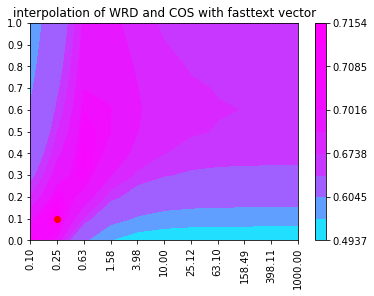

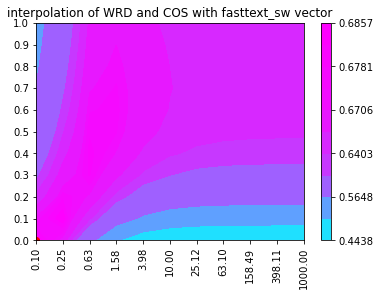

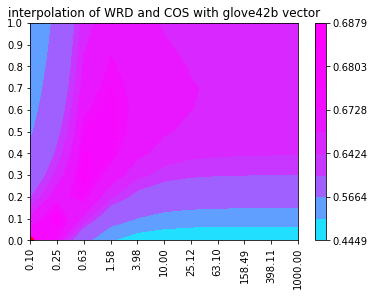

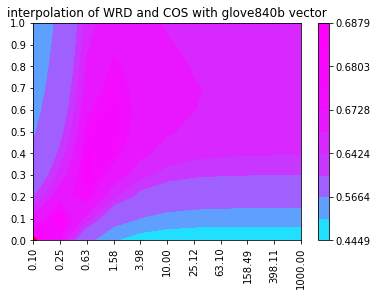

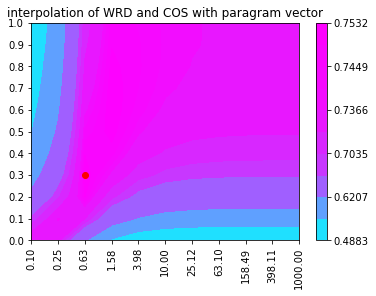

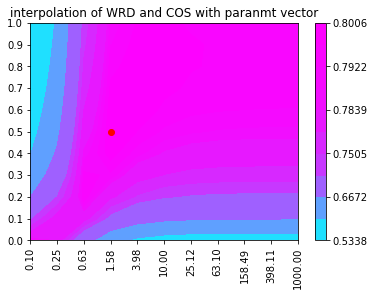

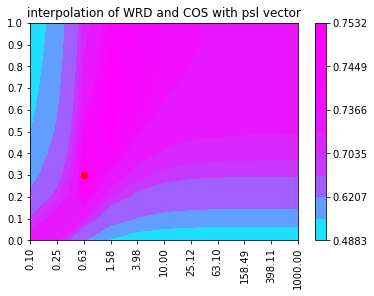

In [154]:
for k in files:
    plot_interp(k)

In [114]:
p_arr[:10]

array([1.00000000e-01, 2.51188643e-01, 6.30957344e-01, 1.58489319e+00,
       3.98107171e+00, 1.00000000e+01, 2.51188643e+01, 6.30957344e+01,
       1.58489319e+02, 3.98107171e+02])

In [173]:
def get_subtable(df, word_vector, merge_STS=False):
    sdf = df[df['word vector'] == word_vector]
    data = defaultdict(list)

    datasets = datasets_core
    models = sdf['model'].unique()
    
    for ds in datasets:
        for m in models:
            _sdf = sdf[sdf['dataset'] == ds]
            _sdf = _sdf[_sdf['model'] == m]
            score_sr = _sdf['score']
            if len(score_sr):
                score = float(score_sr.tolist()[0])
                data[ds].append(score)
                
    if merge_STS:
        sts_list = ["sts:" + str(y) for y in range(2012, 2017)]
        for sts in sts_list:
            score_arr = np.asarray([data[ds] for ds in datasets if sts in ds])
            score = np.mean(score_arr, axis=0).tolist()
            data[sts] = score
        
    nds = pd.DataFrame(data, index=models)
    return nds, data

    

# Major Comparison

In [175]:
from model.word_vector import VectorNames
datasets_short_list = [
    'stsb:test',
    'stsb:dev',
    'twitter:test',
    'sick:r', 
    'sts:2012',
    'sts:2013',
    'sts:2014',
    'sts:2015',
    'sts:2016',
]
datasets_core = [
    'stsb:test',
    'stsb:dev',
    'twitter:test',
    'sick:r',
]

In [243]:
def show_rots(which_rots):
    baselinefiles = {
        'SIF': "log/major_compareSIF210116.11:24:09da939ef8/major_comparison.csv",
        'SIF+adjustwrd': 'log/major_compareSIF+adjustwrd210116.13:31:588a0ecaad/major_comparison.csv',
        'uSIF': "log/major_compareuSIF210116.11:24:56c3ca159f/major_comparison.csv",
        'uSIF+adjustwrd': 'log/major_compareuSIF+adjustwrd210116.13:32:492e8eb879/major_comparison.csv',
        'WRD+SUP': 'log/major_compareWRD+SUP210116.11:26:1295f91d0e/major_comparison.csv',
        'WRD+SUP+adjustcos': 'log/major_compareWRD+SUP+adjustcos210116.14:10:2460969d21/major_comparison.csv',
        'WRD+SWC': 'log/major_compareWRD+SWC210116.11:27:32806d819e/major_comparison.csv',
        'WRD+SWC+adjustcos': 'log/major_compareWRD+SWC+adjustcos210116.14:11:503905b49a/major_comparison.csv',
        'WRD+WR': 'log/major_compareWRD+WR210116.11:28:28975c5ada/major_comparison.csv',
        'WRD+WR+adjustcos': 'log/major_compareWRD+WR+adjustcos210116.14:12:5189077f76/major_comparison.csv',
    }
    rotfiles = {
#         'rotsC1': "log/major_compare_ROTS_C=1/major_comparison.csv",
#         'rotsC2': "log/major_compare_ROTS_C=0/major_comparison.csv",
#         'rotsC3': "log/major_compare_ROTS_C_linear1-0/major_comparison.csv",
    }
    df = pd.DataFrame()
    for k, path in baselinefiles.items():
        _df = pd.read_csv(path)
#         _df['model'] = _df['model'].apply(lambda s: k + "/" + s)
        df = df.append(_df)

    if which_rots in rotfiles:
        _df = pd.read_csv(rotfiles[which_rots])
        _df['model'] = _df['model'].apply(lambda s: which_rots + "/" + s)
        df = df.append(_df)
    for wv in VectorNames:
        nds, _ = get_subtable(df, wv)
        print("="*10)
        print(wv)
        show = nds[datasets_core]
        show['mean'] = show.agg('mean', axis='columns')
        show = show.sort_values('mean', ascending=False)
        print(show.to_string())
        
def get_subtable(df, word_vector, merge_STS=False):
    sdf = df[df['word vector'] == word_vector]
    data = defaultdict(list)

    datasets = datasets_core
    models = sdf['model'].unique()
    
    for ds in datasets:
        for m in models:
            _sdf = sdf[sdf['dataset'] == ds]
            _sdf = _sdf[_sdf['model'] == m]
            score_sr = _sdf['score']
            if len(score_sr):
                score = float(score_sr.tolist()[0])
                data[ds].append(score)
                
    if merge_STS:
        sts_list = ["sts:" + str(y) for y in range(2012, 2017)]
        for sts in sts_list:
            score_arr = np.asarray([data[ds] for ds in datasets if sts in ds])
            score = np.mean(score_arr, axis=0).tolist()
            data[sts] = score
        
    nds = pd.DataFrame(data, index=models)
    return nds, data

In [244]:
show_rots('rotsC1')

psl
                   stsb:test  stsb:dev  twitter:test    sick:r      mean
uSIF                0.735017  0.802653      0.425140  0.719748  0.670640
WRD+SUP             0.737813  0.783879      0.457129  0.678282  0.664276
WRD+WR              0.725187  0.777353      0.450492  0.683765  0.659199
WRD+SWC             0.730094  0.777682      0.459901  0.667336  0.658754
SIF                 0.711279  0.792958      0.402235  0.723722  0.657549
WRD+WR+adjustcos    0.522162  0.637852      0.451321  0.548274  0.539902
WRD+SUP+adjustcos   0.491763  0.605430      0.463646  0.529042  0.522470
WRD+SWC+adjustcos   0.469377  0.588225      0.476041  0.507156  0.510200
uSIF+adjustwrd      0.488338  0.572302      0.323582  0.564223  0.487111
SIF+adjustwrd       0.457198  0.556691      0.318053  0.563815  0.473939
paranmt
                   stsb:test  stsb:dev  twitter:test    sick:r      mean
uSIF                0.795466  0.841124      0.466195  0.738852  0.710409
WRD+SUP             0.790543  0.823551 